In [4]:
import numpy as np
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from omegaconf import OmegaConf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt

from main import ClimateEmulationDataModule, ClimateEmulationModule
from _climate_kaggle_metric import score as kaggle_score

from src.models import SimpleCNN
from src.utils import convert_predictions_to_kaggle_format

## Functions

In [5]:
class ElasticClimateModule(ClimateEmulationModule):
    def __init__(self, model: nn.Module, learning_rate: float, lambda_l1: float = 1e-6, lambda_l2: float = 1e-4):
        super().__init__(model=model, learning_rate=learning_rate)
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2

    def training_step(self, batch, batch_idx):
        x, y_true_norm = batch
        y_pred_norm = self(x)
        loss = self.criterion(y_pred_norm, y_true_norm)

        # Elastic Net Regularization
        l1_penalty = sum(p.abs().sum() for p in self.model.parameters())
        l2_penalty = sum((p ** 2).sum() for p in self.model.parameters())
        reg_loss = self.lambda_l1 * l1_penalty + self.lambda_l2 * l2_penalty

        total_loss = loss + reg_loss

        self.log("train/loss", total_loss, prog_bar=True, batch_size=x.size(0))
        self.log("train/loss_core", loss, prog_bar=False, batch_size=x.size(0))
        self.log("train/loss_l1", self.lambda_l1 * l1_penalty, prog_bar=False, batch_size=x.size(0))
        self.log("train/loss_l2", self.lambda_l2 * l2_penalty, prog_bar=False, batch_size=x.size(0))

        return total_loss


In [6]:
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout3d(dropout),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout3d(dropout),
        )

    def forward(self, x):
        return self.block(x)

class ClimateUNet3D(nn.Module):
    def __init__(self, in_channels=5, out_channels=2, base_channels=32, dropout=0.1):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock3D(in_channels, base_channels, dropout)
        self.pool1 = nn.MaxPool3d((1, 2, 2))

        self.enc2 = ConvBlock3D(base_channels, base_channels * 2, dropout)
        self.pool2 = nn.MaxPool3d((1, 2, 2))

        self.enc3 = ConvBlock3D(base_channels * 2, base_channels * 4, dropout)
        self.pool3 = nn.MaxPool3d((1, 2, 2))

        # Bottleneck
        self.bottleneck = ConvBlock3D(base_channels * 4, base_channels * 8, dropout)

        # Decoder
        self.up3 = nn.ConvTranspose3d(base_channels * 8, base_channels * 4, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec3 = ConvBlock3D(base_channels * 8, base_channels * 4, dropout)

        self.up2 = nn.ConvTranspose3d(base_channels * 4, base_channels * 2, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec2 = ConvBlock3D(base_channels * 4, base_channels * 2, dropout)

        self.up1 = nn.ConvTranspose3d(base_channels * 2, base_channels, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec1 = ConvBlock3D(base_channels * 2, base_channels, dropout)

        # Final output
        self.out_conv = nn.Conv3d(base_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = x.unsqueeze(2)

        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b)
        u3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(u3)

        u2 = self.up2(d3)
        u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2)

        u1 = self.up1(d2)
        u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1)

        out = self.out_conv(d1)
        return out.squeeze(2)


In [7]:
class StoreEpochLosses(Callback):
    def __init__(self):
        self.all_train_losses = []
        self.all_val_losses = []

        self.train_epoch_losses = []
        self.val_epoch_losses = []

        self._train_losses = []
        self._val_losses = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        loss = outputs['loss'] if isinstance(outputs, dict) else outputs
        loss_value = loss.item()

        self._train_losses.append(loss_value)
        self.all_train_losses.append(loss_value)

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        loss = outputs['loss'] if isinstance(outputs, dict) else outputs
        loss_value = loss.item()

        self._val_losses.append(loss_value)
        self.all_val_losses.append(loss_value)

    def on_train_epoch_end(self, trainer, pl_module):
        if self._train_losses:
            avg = sum(self._train_losses) / len(self._train_losses)
            self.train_epoch_losses.append(avg)
            self._train_losses.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        if self._val_losses:
            avg = sum(self._val_losses) / len(self._val_losses)
            self.val_epoch_losses.append(avg)
            self._val_losses.clear()


In [8]:
def plot_batch_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label="Train Loss (per batch)", linewidth=0.8, alpha=0.8)
    plt.plot(val_losses, label="Validation Loss (per batch)", linewidth=0.8, alpha=0.8)

    plt.xlabel("Batch (time)")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_epoch_losses(train_epoch_losses, val_epoch_losses):
    epochs = range(1, len(train_epoch_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_epoch_losses, label='Train Loss (per epoch)', marker='o')
    plt.plot(epochs, val_epoch_losses, label='Validation Loss (per epoch)', marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Training

In [19]:
data_path = 'data/processed_data_cse151b_v2_corrupted_ssp245.zarr'

In [20]:
config = OmegaConf.create({
    "data": {
        "path": data_path,
        # "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "input_vars": ["CO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "target_member_id": 0,
        "batch_size": 32,
        "num_workers": 39,
        
    }
})

In [21]:
data_module = ClimateEmulationDataModule(**config.data)
data_module.setup()

In [32]:
model = ClimateUNet3D(base_channels=64, in_channels=len(config.data['input_vars']))
lightning_module=ClimateEmulationModule(
    model = model,
    learning_rate = 5e-4
)

In [33]:
loss_logger = StoreEpochLosses()

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    callbacks=[loss_logger]    
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(lightning_module, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | ClimateUNet3D | 21.7 M | train
1 | criterion | MSELoss       | 0      | train
----------------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.866    Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


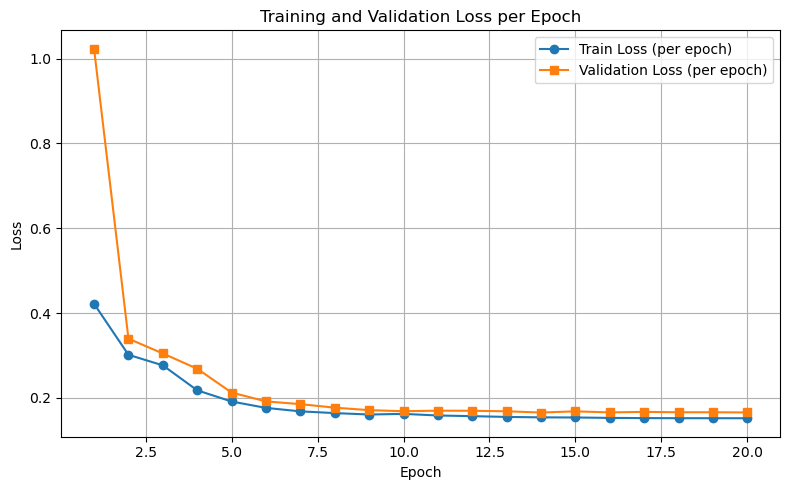

In [35]:
train_losses = loss_logger.train_epoch_losses
val_losses = loss_logger.val_epoch_losses
min_len = min(len(train_losses), len(val_losses))

plot_epoch_losses(train_losses[:min_len], val_losses[:min_len])

## Produce Test Predictions

In [36]:
model.eval()
all_preds = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for x, y_true in data_module.test_dataloader():
    x = x.to(device)
    with torch.no_grad():
        y_pred = model(x.to(device)).squeeze(0)
    all_preds.append(y_pred.cpu().numpy())

y_pred_np = np.concatenate(all_preds, axis=0)
y_pred_output = data_module.normalizer.inverse_transform_output(y_pred_np)

lat_coords, lon_coords = data_module.get_coords()
time_coords = np.arange(y_pred_np.shape[0])
var_names = config.data['output_vars']

In [37]:
submission_df = convert_predictions_to_kaggle_format(
    y_pred_output, time_coords, lat_coords, lon_coords, var_names
)

In [38]:
print(submission_df.shape)

(2488320, 2)


In [39]:
submission_df.to_csv("submission.csv", index=False)